# <center> Uplift-деревья. Практика

Вернемся к продажам товаров с учётом промоакций и скидок. Какое качество покажут аплифт-деревья на этой задаче? Давайте попробуем! Будем работать с теми же датасетами, с которыми мы работали в практиках юнитов 3, 5 и 7.

Итак, давайте поработаем с Uplift-деревьями c помощью библиотеки [CausalML](https://github.com/uber/causalml).


Для начала установим библиотеку (если вы не сделали этого ранее):

In [15]:
#! pip install causalml catboost

Импортируем необходимые библиотеки и загрузим семпл данных

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.model_selection import train_test_split

# Продолжаем решать нашу постановку как задачу классификации - для этого возьмем одно Uplift-дерево и случайный лес
# помним, что основное отличие - это функция разбиения в листе
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

# Прочитаем файл с данными
df = pd.read_csv("data/data.csv")
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target_class
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,2
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,2
3,9,675.83,1,0,Rural,1,Web,Discount,2
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,2


**Справка о признаках:**
* **recency** - количество месяцев с последней покупки клиента
* **history** - общая стоимость исторических покупок
* **used_discount** - указывает, пользовался ли клиент скидкой ранее
* **used_bogo** - указывает, пользовался ли клиент промоакцией ранее
* **zip_code** - класс почтового индекса:
    * Suburban - пригородный
    * Urban - городской
    * Rural - сельский
* **is_referral** - указывает, был ли клиент приобретен по реферальному каналу
* **channel** - каналы, которые использует клиент:
    * Phone - телефон
    * Web - интернет
    * Multichannel - многоканальный
* **treatment** - вид целевого воздействия:
    * **Discount** - было оказано целевое воздействие (предложена скидка)
    * **Buy One Get One** - было оказано целевое воздействие (предложена промоакция)
    * **No Offer** - целевого воздействие не было
* **target_class** - класс клиента (вспомогательный признак):
    * **0 - Control Non-Responders(CN)** 

        Это клиенты, которым не было выдвинуто предложение (целевое воздействие) и они ничего не купили ((y=0, c) в наших терминах)
    * **1 - Control Responders(CR)**

        Это клиенты, совершившие покупку без предложения (целевого воздействия) (y=1, c)
    * **2 - Treatment Non-Responders(CN)**

        Это клиенты, которым было выдвинуто предложение, но они не совершили покупку (y=0, t)
    * **3 - Treatment Responders(CN)** 
        
        Это клиенты, которым было выдвинуто предложение (совершено целевое воздействие) и они совершили покупку (y=1, t)

При построении классификатора нас интересует только факт того, совершил ли клиент покупку (класс 1) или нет (класс 0). Поэтому целевая переменная при классификации - конверсия. 

Посмотрим на распределение целевых влияний в данных:

* Discount - было оказано целевое влияние (предложена скидка)
* Buy One Get One - было оказано целевое влияние (предложена промоакция)
* No Offer - целевого влияния не было

In [17]:
df['treatment'].value_counts()

treatment
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: count, dtype: int64

## Предобработка данных

Подготовим данные:
* Преобразуем целевую переменную в признак конверсии, которую будем прогнозировать (купил/не купил)
* Создадим две отдельные таблицы:
    * В первой будем хранить информацию о пользователях, которым была предложена скидка (df_discount)
    * Во второй будем хранить информацию о пользователях, которым была предложена промоакция (df_bogo)
    
    В каждой из таблиц также сохраним данные о пользователях, на которых не было оказано целевое влияние (контрольная выборка).
* Также произведем кодировку категориальных признаков.

In [18]:
# Новый таргет - бинарная переменная (конверсия): 1 - купил, 0 - не купил
df['conversion'] = df['target_class'].map({0: 0, 1: 1, 2: 0, 3: 1})

# Разделим данные на две таблицы - данные по скидкам и промоакциям

# Выделим пользователей, на которых не было целевого воздействия, и тех, которым мы предлагали скидки
df_discount = df.copy().loc[
    (df['treatment'] == 'No Offer') |  (df['treatment'] == 'Discount')
].reset_index(drop=True)

# Выделим пользователей, на которых не было целевого воздействия, и тех, которым мы предлагали промоакции
df_bogo = df.copy().loc[
    (df['treatment'] == 'No Offer') | (df['treatment'] == 'Buy One Get One')
].reset_index(drop=True)

# Перекодируем столбец с влиянием: 1 - было влияние, 0 - не было
df_discount['treatment'] = df_discount['treatment'].apply(lambda x: 0 if x=='No Offer' else 1)
df_bogo['treatment'] = df_bogo['treatment'].apply(lambda x: 0 if x=='No Offer' else 1)

# Закодируем оставшиеся категориальные признаки
df_discount = pd.get_dummies(df_discount)
df_bogo = pd.get_dummies(df_bogo)

# Выведем размерности полученных таблиц:
print(df_discount.shape)
print(df_bogo.shape)

(42613, 14)
(42693, 14)


Посмотрим на результаты:

In [19]:
df_discount.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,6,329.08,1,1,1,0,0,0,True,False,False,False,False,True
1,9,675.83,1,0,1,1,2,0,True,False,False,False,False,True
2,9,675.07,1,1,1,1,2,0,True,False,False,False,True,False
3,2,101.64,0,1,0,1,3,1,False,False,True,False,False,True
4,4,241.42,0,1,1,0,0,0,True,False,False,True,False,False


In [20]:
df_bogo.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,2,0,False,True,False,False,True,False
1,6,329.08,1,1,1,0,0,0,True,False,False,False,False,True
2,7,180.65,0,1,1,1,2,0,False,True,False,False,False,True
3,2,45.34,1,0,0,1,2,0,False,False,True,False,False,True
4,6,134.83,0,1,0,1,3,1,False,True,False,False,True,False


In [21]:
# Определим колонки с факторами, тритментом и таргетом
feature_cols = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
                'zip_code_Rural', 'zip_code_Surburban', 'zip_code_Urban',
                'channel_Multichannel', 'channel_Phone', 'channel_Web']

target_col = 'conversion'
treatment_col = 'treatment'

## Работаем с данными о скидках

### Обучающая и тестовая выборка

Мы будем работать с данными о скидках. Оценить uplift-эффект на данных о результатх промоакций вам предстоит самостоятельно.

Разделим данные на тренировочную и тестовую выборки.

In [22]:
df_discount_train, df_discount_test = train_test_split(
    df_discount, 
    stratify=df_discount[[treatment_col, target_col]], 
    random_state=13, 
    test_size=0.3
)
print(df_discount_train.shape)
print(df_discount_test.shape)

df_discount_train.head()

(29829, 14)
(12784, 14)


,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
28236,1,616.27,1,0,1,1,2,0,False,False,True,True,False,False
37748,11,158.76,0,1,1,0,0,0,False,False,True,False,False,True
41505,3,269.60,1,0,1,1,2,0,False,False,True,False,True,False
1595,3,458.76,1,0,0,1,2,0,True,False,False,True,False,False
31544,7,209.56,0,1,0,1,2,0,False,False,True,True,False,False


### Quni-curve и qini-score

Создаем функцию для построения qini-curve и расчета qini-score

In [23]:
# Возьмем функцию для оценки qini-curve с прошлого занятия
def qini_df(df, title='train', figsize=(5, 3)):
    # Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    
    # Немного кода для визуализации
    fig = plt.figure(figsize=figsize)
    plt.plot(ranked['n'], ranked['uplift'], color='r', label='Model')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b', label='RandomModel')
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(quni_score))

## Uplift-моделирование с помощью CausalML

Давайте посмотрим на реализацию S-learner и T-learner из библиотеки [CausalML](https://github.com/uber/causalml) от компании Uber ([документация](https://causalml.readthedocs.io/en/latest/index.html)).

### Uplift-tree (CausalML)

Построим простейшее дерево и визуализируем его. 

Подробнее о параметрах UpliftTreeClassifier вы можете прочитать в [документации](https://causalml.readthedocs.io/en/latest/causalml.html#causalml.inference.tree.UpliftTreeClassifier).

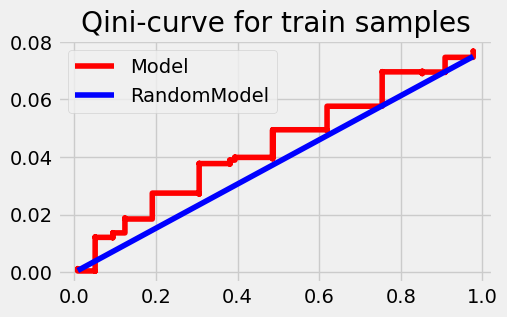

Qini score: 165.908


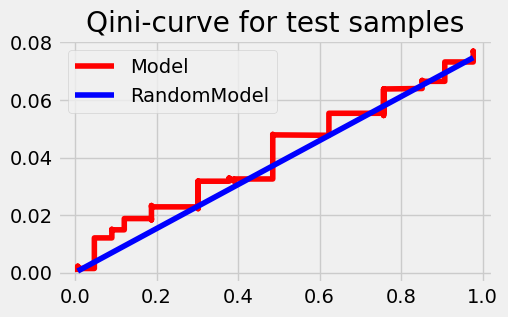

Qini score: 35.212


In [24]:
# Создаем простое дерево.
uplift_tree = UpliftTreeClassifier(
    max_depth=5, min_samples_leaf=200, 
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', 
    control_name='0', random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_tree.fit(
    df_discount_train[feature_cols].values,
    treatment=df_discount_train[treatment_col].apply(str).values,
    y=df_discount_train[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(df_discount_train[feature_cols].values.copy()))[:, 1]
df_discount_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(df_discount_test[feature_cols].values.copy()))[:, 1]
df_discount_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_discount_train, title='train')
qini_df(df_discount_test, title='test')

Можем посмотреть на вид построенного дерева. 

In [25]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz/bin/'

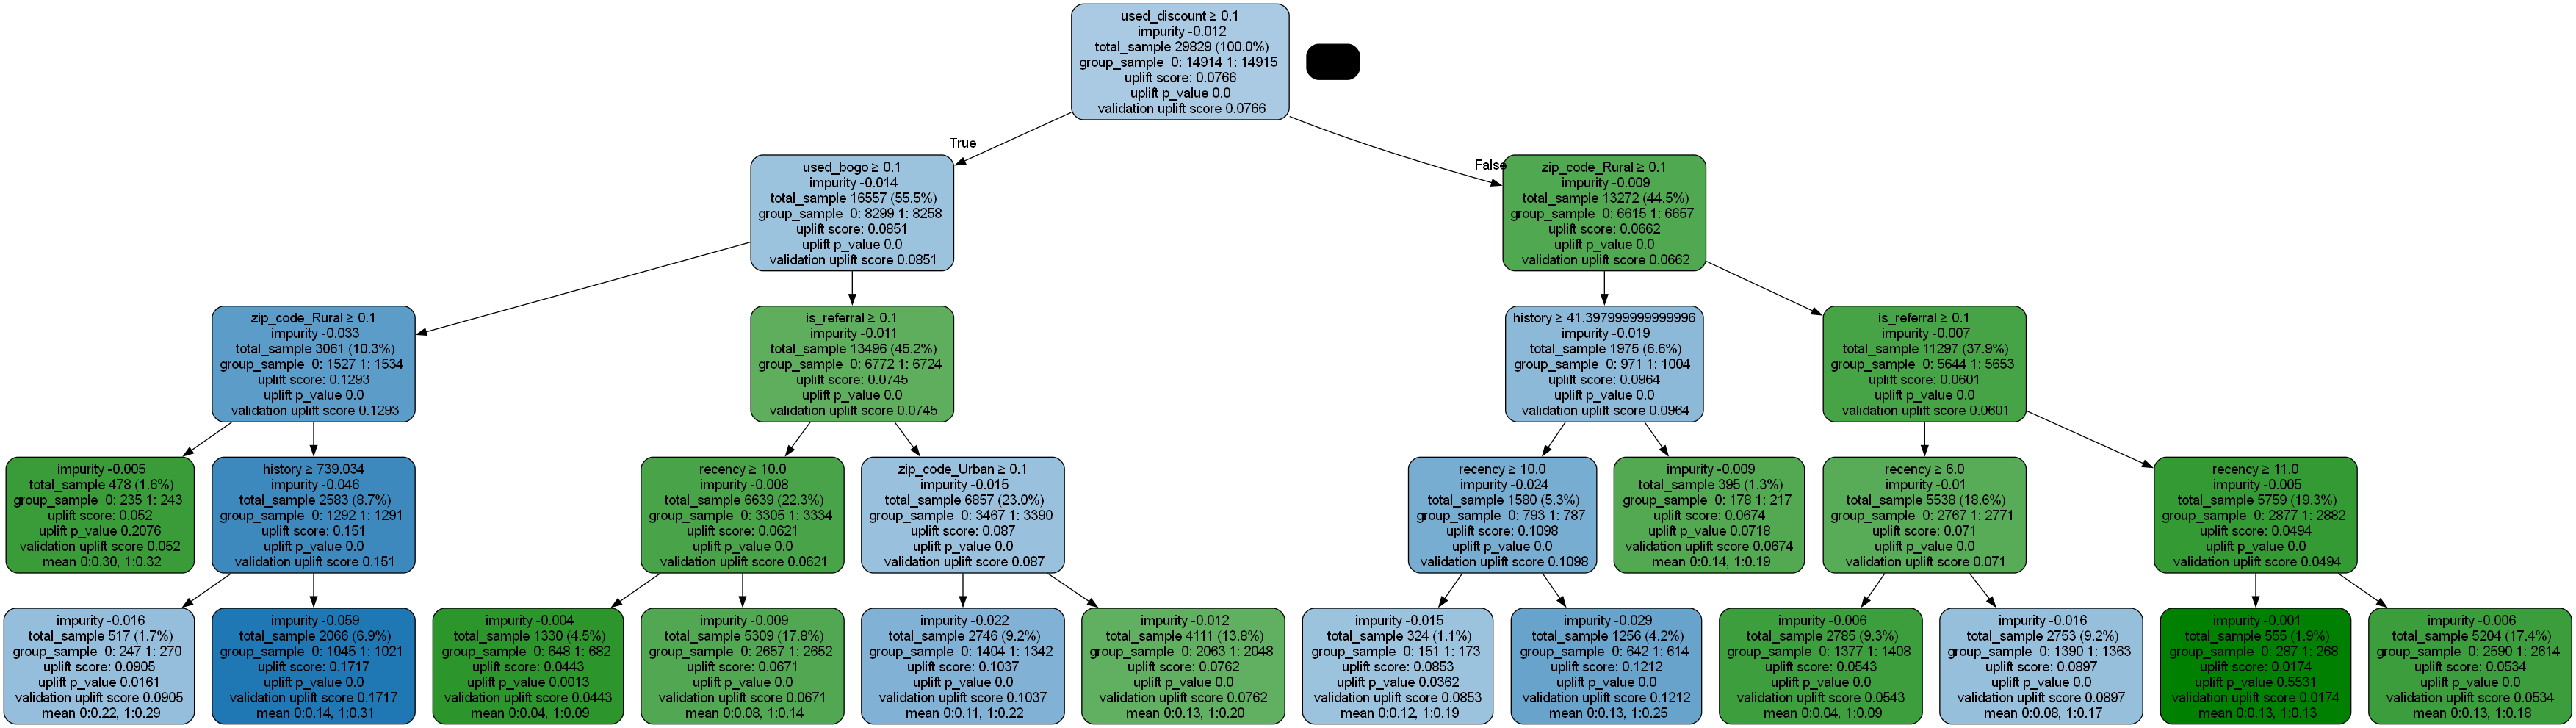

In [26]:
# Давайте визуализируем наше простейшее дерево
from IPython.display import Image
# Вызываем функцию для визуализации:
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, feature_cols)
Image(graph.create_png())

### UpliftRandomForest (CausalML)

Как вы уже догадались, там где есть одно дерево, можно построить целый лес!

Давайте построим случайный лес (UpliftRandomForest) из библиотеки CausalML. 

Подробнее о параметрах UpliftRandomForest вы можете почитать в [документации](https://causalml.readthedocs.io/en/latest/causalml.html#causalml.inference.tree.UpliftRandomForestClassifier). 

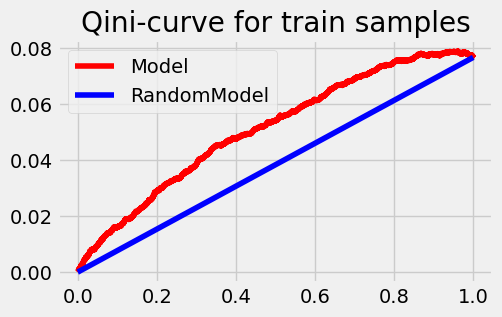

Qini score: 377.109


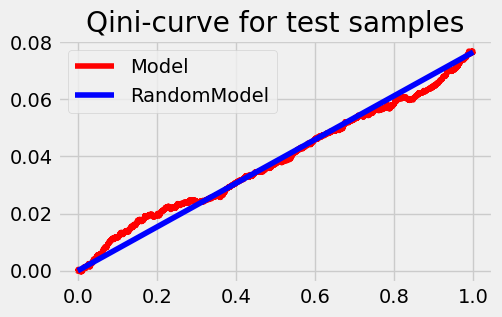

Qini score: 1.161


In [27]:
# Создаем простое дерево.
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_leaf=100, 
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', 
    control_name='0', random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_forest.fit(
    df_discount_train[feature_cols].values,
    treatment=df_discount_train[treatment_col].apply(str).values,
    y=df_discount_train[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_discount_train[feature_cols].values.copy()))
df_discount_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_discount_test[feature_cols].values.copy()))
df_discount_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_discount_train, title='train')
qini_df(df_discount_test, title='test')

Как вы видите, дерево у нас получилось еще ничего, а вот случайный лес получился слишком переобученным. Это можно исправить, правильно подобрав параметры модели.

## Работаем с данными о промоакциях 

Теперь вам предстоит самостоятельно провести uplift-моделирование с помощью Uplift-деревьев и лесов на данных о промоакциях. 

### Обучающая и тестовая выборки

Разделим данные на тренировочную и тестовую выборки.

In [28]:
df_bogo_train, df_bogo_test = train_test_split(
    df_bogo, 
    stratify=df_bogo[[treatment_col, target_col]], 
    random_state=13, 
    test_size=0.3
)
print(df_bogo_train.shape)
print(df_bogo_test.shape)

df_bogo_train.head()

(29885, 14)
(12808, 14)


,recency,history,used_discount,used_bogo,is_referral,treatment,target_class,conversion,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
20518,2,167.94,1,0,1,1,2,0,False,True,False,False,False,True
34388,11,129.29,1,0,0,1,2,0,False,True,False,False,True,False
40663,9,129.61,0,1,1,0,0,0,True,False,False,False,False,True
30626,2,333.87,1,0,1,1,2,0,False,True,False,True,False,False
16372,4,103.79,1,0,1,1,2,0,False,False,True,False,False,True


### Uplift-tree (CausalML)

**Задание №1**

Давайте проведем uplift-моделирование на датасете с промо-акциями (df_bogo) с помощью Uplift-дерева из библиотеки `CausalML` (UpliftTreeClassifier).

В качестве параметров алгоритма укажите следующие:
* max_depth=5
* min_samples_leaf=200
* min_samples_treatment=50
* n_reg=100
* evaluationFunction='ED'
* control_name='0'
* random_state=42

Рассчитайте qini-score на тестовой выборке для полученного Uplift-Дерева. Запишите полученный результат с точностью до 3-его знака после запятой. 

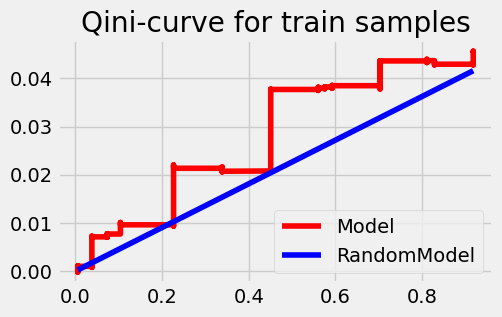

Qini score: 184.794


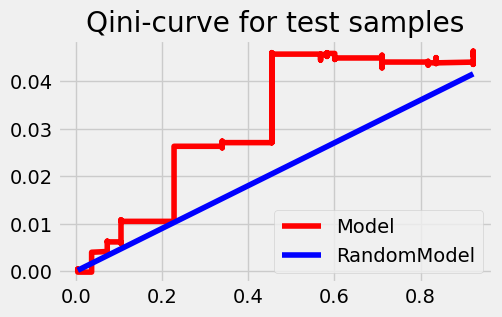

Qini score: 125.963


In [31]:
# ваш код здесь
# Создаем простое дерево.
uplift_tree = UpliftTreeClassifier(
    max_depth=5, min_samples_leaf=200, 
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', 
    control_name='0', random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_tree.fit(
    df_bogo_train[feature_cols].values,
    treatment=df_bogo_train[treatment_col].apply(str).values,
    y=df_bogo_train[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(df_bogo_train[feature_cols].values.copy()))[:, 1]
df_bogo_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_tree.predict(np.array(df_bogo_test[feature_cols].values.copy()))[:, 1]
df_bogo_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_bogo_train, title='train')
qini_df(df_bogo_test, title='test')

### UpliftRandomForestClassifier (CausalML)

**Задание №2**

Давайте проведем uplift-моделирование на датасете с промо-акциями (df_bogo) с помощью UpliftRandomForest из библиотеки `CausalML` (UpliftRandomForestClassifier).

В качестве параметров алгоритма укажите следующие:
* n_estimators=100
* max_depth=5
* min_samples_leaf=200
* min_samples_treatment=50
* n_reg=100
* evaluationFunction='ED'
* control_name='0'
* random_state=42

Рассчитайте qini-score на тестовой выборке для полученного UpliftRandomForest. Запишите полученный результат с точностью до 3-его знака после запятой. 

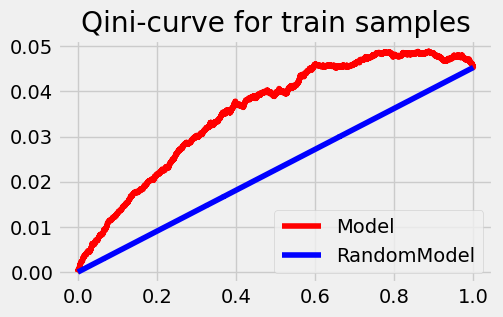

Qini score: 380.740


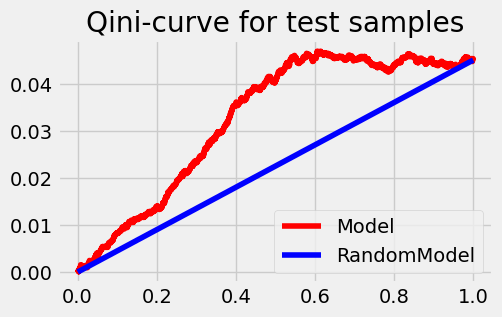

Qini score: 128.505


In [34]:
# ваш код здесь
# Создаем простое дерево.
uplift_forest = UpliftRandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_leaf=200, 
    min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', 
    control_name='0', random_state=42
)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
# Обратите внимание, что для использования деревьев из CausalML нам необходимо преобразовать фактор воздействия в строку
uplift_forest.fit(
    df_bogo_train[feature_cols].values,
    treatment=df_bogo_train[treatment_col].apply(str).values,
    y=df_bogo_train[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_bogo_train[feature_cols].values.copy()))
df_bogo_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
# Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия
# Нас интересует только наличие воздействия (столбец под индексом 1)
uplift_vals = uplift_forest.predict(np.array(df_bogo_test[feature_cols].values.copy()))
df_bogo_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_bogo_train, title='train')
qini_df(df_bogo_test, title='test')